# MLE Project - Sorting Classical Composers via MIDI Files

Import MIDI Files and Prepare Data for Model

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%pip install pretty_midi numpy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 13.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.6/54.6 kB 5.4 MB/s eta 0:00:00
  Created wheel for pretty_midi: filename=pretty_midi-0.2.11-py3-none-any.whl size=5595886 sha256=ebd51833101412f2ca58743e351bede9c272d511efced34f9fb3af2cba199fb3
  Stored in directory: /root/.cache/pip/wheels/f4/ad/93/a7042fe12668827574927ade9deec7f29aad2a1001b1501882
Successfully built pretty_midi


In [3]:
import os
import pretty_midi
import re # Import the regular expression module

midi_dir = '/content/drive/MyDrive/midi_files_21'
midi_objects = []
midi_labels = [] # Initialize an empty list for labels

# Define the mapping from original labels to new labels as requested
label_mapping = {
    6: 0,
    2: 1,
    15: 2,
    16:3,
    10:4,
    13:5
}

for filename in os.listdir(midi_dir):
    if filename.endswith('.mid') or filename.endswith('.midi'):
        filepath = os.path.join(midi_dir, filename)
        try:
            midi_data = pretty_midi.PrettyMIDI(filepath)

            # Extract numerical prefix
            match = re.match(r'^(\d+)', filename)
            if match:
                original_label = int(match.group(1)) - 1 # Get the label as it was originally extracted
                # Apply the new mapping
                if original_label in label_mapping:
                    mapped_label = label_mapping[original_label]
                    midi_objects.append(midi_data)
                    midi_labels.append(mapped_label)
                else:
                    print(f"Warning: Original label {original_label} from {filename} not found in the specified mapping. Skipping.")
            else:
                print(f"Could not extract numerical label from {filename}. Skipping.")
        except Exception as e:
            print(f"Could not parse {filepath}: {e}")

print(f"Successfully parsed {len(midi_objects)} MIDI files and extracted {len(midi_labels)} labels.")
print(midi_labels) # Print first 10 labels for a quick check

Successfully parsed 126 MIDI files and extracted 126 labels.
[5, 3, 3, 2, 2, 0, 1, 2, 5, 5, 4, 1, 3, 5, 3, 1, 2, 5, 5, 4, 0, 5, 3, 3, 5, 4, 2, 3, 1, 0, 1, 4, 0, 5, 1, 2, 2, 3, 1, 2, 0, 4, 0, 4, 2, 3, 5, 4, 1, 2, 3, 1, 1, 2, 2, 4, 3, 4, 1, 5, 5, 1, 5, 3, 2, 2, 0, 0, 4, 2, 0, 5, 3, 5, 2, 4, 0, 1, 2, 5, 1, 4, 3, 4, 0, 1, 3, 3, 5, 4, 5, 4, 1, 3, 0, 4, 4, 0, 2, 2, 0, 1, 0, 1, 0, 0, 4, 2, 4, 2, 3, 5, 1, 3, 0, 4, 0, 1, 5, 1, 5, 0, 4, 3, 0, 3]


In [4]:
def extract_note_data(midi_object):
    """
    Extracts relevant note information from a pretty_midi.PrettyMIDI object.

    Args:
        midi_object: A pretty_midi.PrettyMIDI object.

    Returns:
        A list of dictionaries, where each dictionary represents a note and
        contains its pitch, start time, end time, and velocity.
    """
    note_data = []
    for instrument in midi_object.instruments:
        for note in instrument.notes:
            note_data.append({
                'pitch': note.pitch,
                'start': note.start,
                'end': note.end,
                'velocity': note.velocity
            })
    return note_data

In [5]:
def create_sequences(data, sequence_length, step):
    """
    Creates sequences from a NumPy array using a sliding window.

    Args:
        data: Input NumPy array of shape (number_of_notes, number_of_features).
        sequence_length: The desired length of each sequence.
        step: The step size for the sliding window.

    Returns:
        A NumPy array of shape (number_of_sequences, sequence_length, number_of_features).
    """
    sequences = []
    for i in range(0, len(data) - sequence_length + 1, step):
        sequences.append(data[i:i + sequence_length])
    return np.array(sequences)

# Determine sequence length and step size (these are hyperparameters you might tune)
sequence_length = 100  # Example sequence length
step = 4  # Example step size for sliding window

In [6]:
import numpy as np
from sklearn.model_selection import train_test_split

all_labeled_sequences = []
all_corresponding_labels = []

for i, midi_object in enumerate(midi_objects):
    label = midi_labels[i] # Get the label for the current MIDI object

    # Extract note data
    note_data = extract_note_data(midi_object)

    # Convert list of dictionaries to a list of lists
    note_data_list = []
    for note in note_data:
        note_data_list.append([note['pitch'], note['start'], note['end'], note['velocity']])

    if note_data_list: # Check if note_data_list is not empty
        note_array = np.array(note_data_list, dtype=np.float32)

        # Create sequences from the note_array
        note_sequences = create_sequences(note_array, sequence_length, step)

        if note_sequences.size > 0: # Check if note_sequences is not empty
            all_labeled_sequences.append(note_sequences)
            # Each sequence generated from this midi_object will have the same label
            all_corresponding_labels.append(np.full(note_sequences.shape[0], label, dtype=np.int32))
    else:
        print(f"Skipping a MIDI file with no note data or sequences from midi_objects[{i}].")

# Consolidate all sequences and labels
X_labeled = np.concatenate(all_labeled_sequences, axis=0)
y_labeled = np.concatenate(all_corresponding_labels, axis=0)

num_classes = len(np.unique(y_labeled))

print("Shape of X_labeled (input sequences for classification):", X_labeled.shape)
print("Shape of y_labeled (target labels for classification):", y_labeled.shape)
print(f"Number of unique classes: {num_classes}")

Shape of X_labeled (input sequences for classification): (86080, 100, 4)
Shape of y_labeled (target labels for classification): (86080,)
Number of unique classes: 6


In [7]:
X_train, X_test, y_train, y_test = train_test_split(X_labeled, y_labeled, test_size=0.2, random_state=42)

print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

X_train shape: (68864, 100, 4)
y_train shape: (68864,)
X_test shape: (17216, 100, 4)
y_test shape: (17216,)


In [8]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Input

model_labeled = Sequential()
model_labeled.add(Input(shape=(X_train.shape[1], X_train.shape[2])))
model_labeled.add(LSTM(128, return_sequences=False)) # LSTM layer
model_labeled.add(Dense(num_classes, activation='softmax')) # Output layer for multi-class classification

model_labeled.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 128)            │        68,096 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 68,870 (269.02 KB)

 Trainable params: 68,870 (269.02 KB)

 Non-trainable params: 0 (0.00 B)

In [9]:
model_labeled.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [10]:
history_labeled = model_labeled.fit(X_train, y_train, epochs=350, batch_size=64, validation_split=0.2)

Epoch 1/350
861/861 ━━━━━━━━━━━━━━━━━━━━ 13s 10ms/step - accuracy: 0.2986 - loss: 1.6251 - val_accuracy: 0.3227 - val_loss: 1.5611
Epoch 2/350
861/861 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - accuracy: 0.3262 - loss: 1.5503 - val_accuracy: 0.3266 - val_loss: 1.5295
Epoch 3/350
861/861 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - accuracy: 0.3340 - loss: 1.5302 - val_accuracy: 0.3416 - val_loss: 1.5298
Epoch 4/350
861/861 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - accuracy: 0.3502 - loss: 1.5097 - val_accuracy: 0.3574 - val_loss: 1.4985
Epoch 5/350
861/861 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - accuracy: 0.3543 - loss: 1.4983 - val_accuracy: 0.3634 - val_loss: 1.4985
Epoch 6/350
861/861 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - accuracy: 0.3604 - loss: 1.4877 - val_accuracy: 0.3646 - val_loss: 1.4828
Epoch 7/350
861/861 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - accuracy: 0.3691 - loss: 1.4799 - val_accuracy: 0.3700 - val_loss: 1.4678
Epoch 8/350
861/861 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - accuracy: 0.3742 - loss: 1.4668 - val_

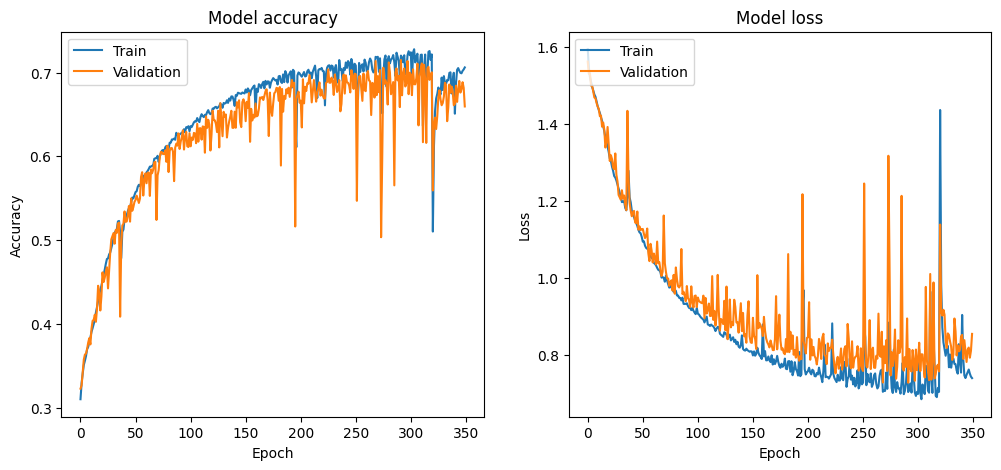

In [11]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history_labeled.history['accuracy'])
plt.plot(history_labeled.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history_labeled.history['loss'])
plt.plot(history_labeled.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Task
Predict labels on the test set using `model_labeled` and `X_test`, then calculate and visualize the confusion matrix using `y_test` and the predicted labels.

## Predict labels on the test set

### Subtask:
Use the trained model to predict the class labels for the `X_test` data.


**Reasoning**:
The subtask is to predict class labels for the `X_test` data using the trained model. This involves getting probability predictions and then converting them to discrete class labels.



In [12]:
y_pred_probs = model_labeled.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)

print("Shape of predicted probabilities (y_pred_probs):", y_pred_probs.shape)
print("Shape of predicted labels (y_pred):", y_pred.shape)
print("First 10 predicted probabilities:\n", y_pred_probs[:10])
print("First 10 predicted labels:", y_pred[:10])

538/538 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
Shape of predicted probabilities (y_pred_probs): (17216, 6)
Shape of predicted labels (y_pred): (17216,)
First 10 predicted probabilities:
 [[3.3280114e-03 3.4142366e-05 9.9614090e-01 4.6512435e-04 7.0993802e-09
  3.1769174e-05]
 [1.8323878e-02 9.8063827e-01 9.5489988e-04 6.2558080e-05 1.6938711e-05
  3.4021080e-06]
 [1.0590855e-01 2.4451081e-01 4.9918053e-01 8.9414613e-03 1.1059822e-02
  1.3039877e-01]
 [2.0473073e-03 1.1115429e-01 9.7033698e-03 3.9662910e-03 2.4230070e-01
  6.3082802e-01]
 [2.6077468e-02 1.5864691e-01 8.2558341e-02 6.7240518e-01 2.3833329e-02
  3.6478758e-02]
 [4.9348831e-02 7.3774403e-01 1.3580248e-01 5.7737030e-02 1.1685948e-02
  7.6815691e-03]
 [4.3662828e-03 7.4904128e-03 7.5088441e-04 3.0841784e-05 1.3804074e-01
  8.4932077e-01]
 [1.7911658e-01 4.4984022e-01 1.1189015e-01 8.3795842e-03 1.4453156e-01
  1.0624187e-01]
 [3.5684043e-13 1.1715949e-04 1.6487090e-07 6.5195876e-11 1.0835811e-06
  9.9988163e-01]
 [4.5696198e-04 2.

In [13]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

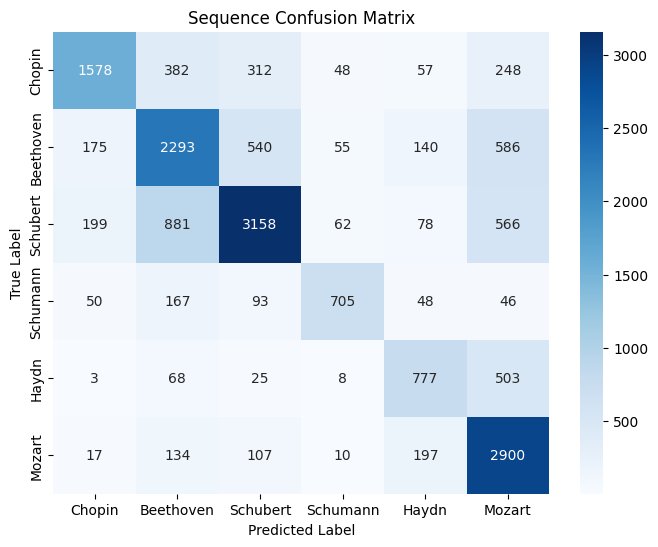

In [27]:
plt.figure(figsize=(8, 6))
# Define the composer names for the labels, assuming the same order as before
class_names = ['Chopin', 'Beethoven', 'Schubert', 'Schumann', 'Haydn', 'Mozart']
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.title('Sequence Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

## Process and Predict per MIDI File rather than per Sequence


In [15]:
file_level_predictions = [] # To store predicted probabilities for sequences from each MIDI file
file_level_true_labels = [] # To store the true label for each MIDI file

processed_midi_count = 0

for i, midi_object in enumerate(midi_objects):
    label = midi_labels[i] # Get the true label for the current MIDI object

    # a. Extract note data from the midi_object
    note_data = extract_note_data(midi_object)

    # b. Convert list of dictionaries to a list of lists, then to a NumPy array
    note_data_list = []
    for note in note_data:
        note_data_list.append([note['pitch'], note['start'], note['end'], note['velocity']])

    if note_data_list: # Ensure there is note data to process
        note_array = np.array(note_data_list, dtype=np.float32)

        # c. Create sequences from this NumPy array
        note_sequences = create_sequences(note_array, sequence_length, step)

        # d. If sequences were successfully created:
        if note_sequences.size > 0: # Check if note_sequences is not empty
            # i. Use model_labeled.predict() to get the probability predictions
            sequence_predictions = model_labeled.predict(note_sequences, verbose=0)
            file_level_predictions.append(sequence_predictions)

            # iii. Append the true label (repeated for the number of sequences)
            file_level_true_labels.append(np.full(note_sequences.shape[0], label, dtype=np.int32))
            processed_midi_count += 1
        else:
            print(f"Skipping MIDI object at index {i} due to no sequences being generated.")
    else:
        print(f"Skipping MIDI object at index {i} due to no note data.")

# 3. Print verification messages
print(f"Total MIDI files processed for predictions: {processed_midi_count}")
print(f"Length of file_level_predictions list: {len(file_level_predictions)}")
print(f"Length of file_level_true_labels list: {len(file_level_true_labels)}")

Total MIDI files processed for predictions: 126
Length of file_level_predictions list: 126
Length of file_level_true_labels list: 126


## Aggregate Predictions and Determine File-Level Labels




In [16]:
final_file_predictions = []
final_file_true_labels = []

for i in range(len(file_level_predictions)):
    # Get predictions for all sequences of the current MIDI file
    current_midi_sequence_predictions = file_level_predictions[i]

    # Calculate the mean of these probabilities across sequences
    # This gives an average probability distribution for the entire MIDI file
    averaged_predictions = np.mean(current_midi_sequence_predictions, axis=0)

    # Determine the single predicted class label for the MIDI file using argmax
    predicted_label = np.argmax(averaged_predictions)

    # Append the predicted label to the final list
    final_file_predictions.append(predicted_label)

    # Append the true label for the current MIDI file
    # All elements in file_level_true_labels[i] are the same, so taking the first one is sufficient
    true_label = file_level_true_labels[i][0]
    final_file_true_labels.append(true_label)

# Convert lists to NumPy arrays
final_file_predictions = np.array(final_file_predictions)
final_file_true_labels = np.array(final_file_true_labels)

# Print shapes and first few elements for verification
print("Shape of final_file_predictions:", final_file_predictions.shape)
print("First 10 final_file_predictions:", final_file_predictions[:10])
print("Shape of final_file_true_labels:", final_file_true_labels.shape)
print("First 10 final_file_true_labels:", final_file_true_labels[:10])

Shape of final_file_predictions: (126,)
First 10 final_file_predictions: [5 3 3 2 2 0 1 2 5 5]
Shape of final_file_true_labels: (126,)
First 10 final_file_true_labels: [5 3 3 2 2 0 1 2 5 5]


# Calculate the Accuracy of the Model when used on entire MIDI files



## File-Level Train-Test Split for Unbiased Evaluation

To ensure that our file-level accuracy is truly representative of the model's performance on unseen data, we must split the original `midi_objects` and their `midi_labels` into training and testing sets *before* generating any sequences. This guarantees that none of the MIDI files used for the final file-level evaluation have had any of their sequences used during the model's training phase.

In [17]:
from sklearn.model_selection import train_test_split

# Perform train-test split on the MIDI files themselves
midi_objects_train, midi_objects_test, midi_labels_train, midi_labels_test = train_test_split(
    midi_objects, midi_labels, test_size=0.2, random_state=42, stratify=midi_labels
)

print(f"Number of MIDI files in training set: {len(midi_objects_train)}")
print(f"Number of MIDI files in testing set: {len(midi_objects_test)}")
print(f"First 5 training labels: {midi_labels_train[:5]}")
print(f"First 5 testing labels: {midi_labels_test[:5]}")

Number of MIDI files in training set: 100
Number of MIDI files in testing set: 26
First 5 training labels: [0, 3, 0, 2, 5]
First 5 testing labels: [2, 1, 5, 4, 3]


## Generating Sequences and Predictions for Test MIDI Files

Now, we will iterate only through the `midi_objects_test` to generate sequences and obtain predictions using our trained `model_labeled`. This ensures that all sequences processed here come from MIDI files that were explicitly held out from the training process.

In [18]:
test_file_level_sequence_predictions = [] # To store predicted probabilities for sequences from each test MIDI file
test_file_level_true_labels = [] # To store the true label for each test MIDI file

processed_test_midi_count = 0

for i, midi_object in enumerate(midi_objects_test):
    label = midi_labels_test[i] # Get the true label for the current test MIDI object

    note_data = extract_note_data(midi_object)

    note_data_list = []
    for note in note_data:
        note_data_list.append([note['pitch'], note['start'], note['end'], note['velocity']])

    if note_data_list: # Ensure there is note data to process
        note_array = np.array(note_data_list, dtype=np.float32)

        note_sequences = create_sequences(note_array, sequence_length, step)

        if note_sequences.size > 0: # Check if note_sequences is not empty
            # Use model_labeled.predict() to get the probability predictions
            sequence_predictions = model_labeled.predict(note_sequences, verbose=0)
            test_file_level_sequence_predictions.append(sequence_predictions)

            # Append the true label (repeated for the number of sequences)
            test_file_level_true_labels.append(np.full(note_sequences.shape[0], label, dtype=np.int32))
            processed_test_midi_count += 1
        else:
            print(f"Skipping test MIDI object at index {i} due to no sequences being generated.")
    else:
        print(f"Skipping test MIDI object at index {i} due to no note data.")

print(f"Total test MIDI files processed for predictions: {processed_test_midi_count}")
print(f"Length of test_file_level_sequence_predictions list: {len(test_file_level_sequence_predictions)}")
print(f"Length of test_file_level_true_labels list: {len(test_file_level_true_labels)}")

Total test MIDI files processed for predictions: 26
Length of test_file_level_sequence_predictions list: 26
Length of test_file_level_true_labels list: 26


## Aggregate Predictions and Calculate True File-Level Test Accuracy

Now we will aggregate the sequence-level predictions for each test MIDI file using the average probability voting mechanism and then calculate the final file-level accuracy on this unseen test data.

In [19]:
final_test_file_predictions = []
final_test_file_true_labels = []

for i in range(len(test_file_level_sequence_predictions)):
    current_midi_sequence_predictions = test_file_level_sequence_predictions[i]

    averaged_predictions = np.mean(current_midi_sequence_predictions, axis=0)

    predicted_label = np.argmax(averaged_predictions)

    final_test_file_predictions.append(predicted_label)

    true_label = test_file_level_true_labels[i][0]
    final_test_file_true_labels.append(true_label)

final_test_file_predictions = np.array(final_test_file_predictions)
final_test_file_true_labels = np.array(final_test_file_true_labels)

from sklearn.metrics import accuracy_score, confusion_matrix

# Calculate true file-level accuracy on the test set
true_file_level_accuracy = accuracy_score(final_test_file_true_labels, final_test_file_predictions)

print(f"True file-level classification accuracy on test set: {true_file_level_accuracy:.4f}")

True file-level classification accuracy on test set: 1.0000


## Visualize True File-Level Test Confusion Matrix

Finally, let's visualize the confusion matrix for this true file-level test accuracy to understand the model's performance on unseen complete MIDI files.

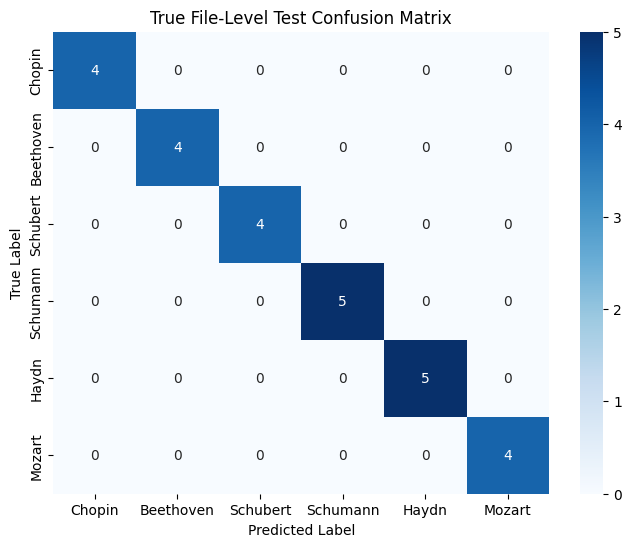

In [25]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

cm_true_file_level = confusion_matrix(final_test_file_true_labels, final_test_file_predictions)

# Define the composer names for the labels
class_names = ['Chopin', 'Beethoven', 'Schubert', 'Schumann', 'Haydn', 'Mozart']

plt.figure(figsize=(8, 6))
sns.heatmap(cm_true_file_level, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.title('True File-Level Test Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [21]:


# Calculate the file-level confusion matrix
cm_file_level = confusion_matrix(final_file_true_labels, final_file_predictions)

Calculate the accuracy when model is applied to entire MIDI file dataset instead of only training data

In [22]:
from sklearn.metrics import accuracy_score

# Calculate file-level accuracy
file_level_accuracy = accuracy_score(final_file_true_labels, final_file_predictions)

print(f"File-level classification accuracy: {file_level_accuracy:.4f}")

File-level classification accuracy: 0.9921


# Visualizing Probability Voting

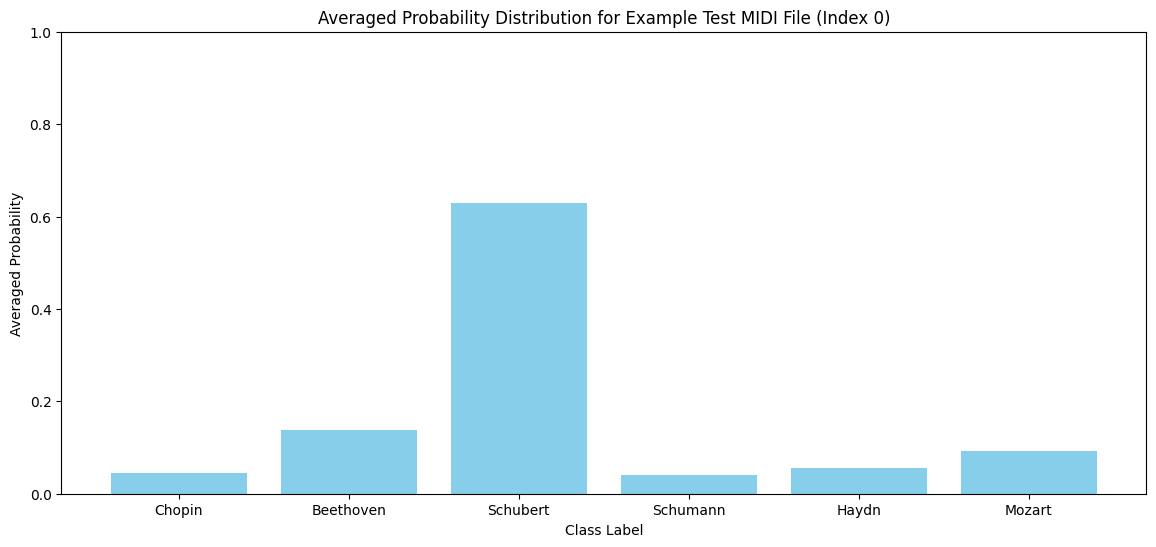

In [26]:
import matplotlib.pyplot as plt
import numpy as np

# Select an example file (e.g., the first one in the list) from the test set
example_file_index = 0
example_sequence_predictions = test_file_level_sequence_predictions[example_file_index]

# Calculate the average probability distribution for this file
averaged_probs_for_example_file = np.mean(example_sequence_predictions, axis=0)

# Get the number of classes
num_classes = len(averaged_probs_for_example_file)
# Use the defined class names for the labels
class_labels = ['Chopin', 'Beethoven', 'Schubert', 'Schumann', 'Haydn', 'Mozart']

plt.figure(figsize=(14, 6))
plt.bar(class_labels, averaged_probs_for_example_file, color='skyblue')
plt.xlabel('Class Label')
plt.ylabel('Averaged Probability')
plt.title(f'Averaged Probability Distribution for Example Test MIDI File (Index {example_file_index})')
plt.ylim(0, 1) # Probabilities are between 0 and 1
plt.show()

This plot shows the averaged probability that the model assigned to each of the 6 classes for the first MIDI file. The highest bar indicates the class the model is most confident about for this particular file.